In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset & Dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs=128

transform = transforms.Compose([
    transforms.
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [4]:
train_set

Dataset ImageFolder
    Number of datapoints: 40000
    Root location: data/train/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

[N, C, H, W]

In [29]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 1, 28, 28])

In [25]:
label2cat = train_set.classes

## Arsitektur & Config

In [7]:
from jcopdl.layers import linear_block

In [8]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            
            linear_block(input_size, n1, dropout=dropout),
            
            linear_block(n1, n2, dropout=dropout),
            
            linear_block(n2, output_size, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(x)

In [9]:
config = set_config({
    "input_size" : 784,
    "n1" : 256,
    "n2" : 64,
    "output_size" : len(train_set.classes),
    "dropout" : 0.2
})

## Training Preparation => MCOC

In [10]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

callback = Callback(model, config, outdir="model")

## Training

In [11]:
from tqdm.auto import tqdm

In [12]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0

    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        # feedforward
        output = model(feature)
        # hitung cost
        loss = criterion(output, target)
        
        if mode == "train":
            # backprop
            loss.backward()
            # update weight
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.7212 | Test_cost  = 0.4660 | Train_score = 0.7466 | Test_score = 0.8287 |




Epoch     2
Train_cost  = 0.4724 | Test_cost  = 0.4115 | Train_score = 0.8332 | Test_score = 0.8471 |




Epoch     3
Train_cost  = 0.4239 | Test_cost  = 0.3728 | Train_score = 0.8485 | Test_score = 0.8642 |




Epoch     4
Train_cost  = 0.3899 | Test_cost  = 0.3669 | Train_score = 0.8609 | Test_score = 0.8632 |
==> EarlyStop patience =  1 | Best test_score: 0.8642




Epoch     5
Train_cost  = 0.3670 | Test_cost  = 0.3521 | Train_score = 0.8687 | Test_score = 0.8682 |




Epoch     6
Train_cost  = 0.3541 | Test_cost  = 0.3440 | Train_score = 0.8719 | Test_score = 0.8709 |




Epoch     7
Train_cost  = 0.3392 | Test_cost  = 0.3279 | Train_score = 0.8784 | Test_score = 0.8804 |




Epoch     8
Train_cost  = 0.3285 | Test_cost  = 0.3244 | Train_score = 0.8810 | Test_score = 0.8813 |




Epoch     9
Train_cost  = 0.3159 | Test_cost  = 0.3301 | Train_score = 0.8858 | Test_score = 0.8787 |
==> EarlyStop patience =  1 | Best test_score: 0.8813




Epoch    10
Train_cost  = 0.3113 | Test_cost  = 0.3214 | Train_score = 0.8877 | Test_score = 0.8828 |




Epoch    11
Train_cost  = 0.2975 | Test_cost  = 0.3123 | Train_score = 0.8916 | Test_score = 0.8854 |




Epoch    12
Train_cost  = 0.2925 | Test_cost  = 0.3119 | Train_score = 0.8940 | Test_score = 0.8873 |




Epoch    13
Train_cost  = 0.2867 | Test_cost  = 0.3192 | Train_score = 0.8946 | Test_score = 0.8844 |
==> EarlyStop patience =  1 | Best test_score: 0.8873




Epoch    14
Train_cost  = 0.2796 | Test_cost  = 0.3278 | Train_score = 0.8983 | Test_score = 0.8793 |
==> EarlyStop patience =  2 | Best test_score: 0.8873




Epoch    15
Train_cost  = 0.2725 | Test_cost  = 0.3092 | Train_score = 0.8994 | Test_score = 0.8890 |




Epoch    16
Train_cost  = 0.2658 | Test_cost  = 0.3123 | Train_score = 0.9014 | Test_score = 0.8848 |
==> EarlyStop patience =  1 | Best test_score: 0.8890




Epoch    17
Train_cost  = 0.2658 | Test_cost  = 0.3222 | Train_score = 0.9023 | Test_score = 0.8840 |
==> EarlyStop patience =  2 | Best test_score: 0.8890




Epoch    18
Train_cost  = 0.2564 | Test_cost  = 0.3043 | Train_score = 0.9054 | Test_score = 0.8894 |




Epoch    19
Train_cost  = 0.2532 | Test_cost  = 0.3317 | Train_score = 0.9068 | Test_score = 0.8790 |
==> EarlyStop patience =  1 | Best test_score: 0.8894




Epoch    20
Train_cost  = 0.2496 | Test_cost  = 0.3006 | Train_score = 0.9061 | Test_score = 0.8918 |


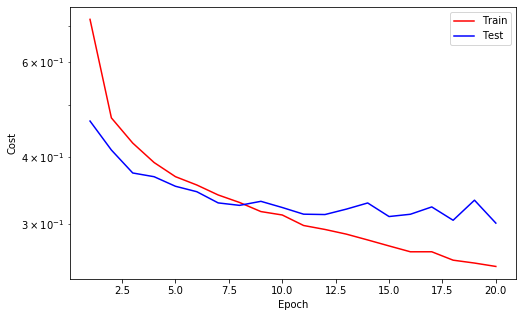

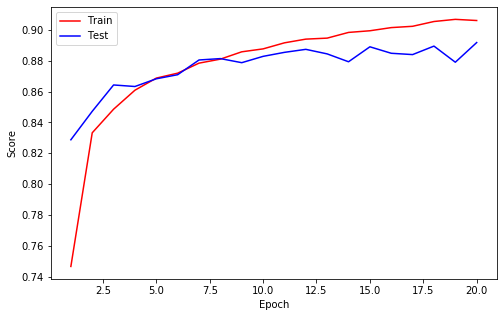



Epoch    21
Train_cost  = 0.2446 | Test_cost  = 0.3111 | Train_score = 0.9095 | Test_score = 0.8890 |
==> EarlyStop patience =  1 | Best test_score: 0.8918




Epoch    22
Train_cost  = 0.2391 | Test_cost  = 0.3334 | Train_score = 0.9109 | Test_score = 0.8833 |
==> EarlyStop patience =  2 | Best test_score: 0.8918




Epoch    23
Train_cost  = 0.2360 | Test_cost  = 0.3094 | Train_score = 0.9115 | Test_score = 0.8921 |




Epoch    24
Train_cost  = 0.2271 | Test_cost  = 0.3202 | Train_score = 0.9153 | Test_score = 0.8873 |
==> EarlyStop patience =  1 | Best test_score: 0.8921




Epoch    25
Train_cost  = 0.2286 | Test_cost  = 0.3213 | Train_score = 0.9151 | Test_score = 0.8897 |
==> EarlyStop patience =  2 | Best test_score: 0.8921




Epoch    26
Train_cost  = 0.2241 | Test_cost  = 0.3165 | Train_score = 0.9147 | Test_score = 0.8901 |
==> EarlyStop patience =  3 | Best test_score: 0.8921




Epoch    27
Train_cost  = 0.2232 | Test_cost  = 0.3058 | Train_score = 0.9176 | Test_score = 0.8915 |
==> EarlyStop patience =  4 | Best test_score: 0.8921




Epoch    28
Train_cost  = 0.2177 | Test_cost  = 0.3113 | Train_score = 0.9188 | Test_score = 0.8921 |
==> EarlyStop patience =  5 | Best test_score: 0.8921
==> Execute Early Stopping at epoch: 28 | Best test_score: 0.8921
==> Best model is saved at model


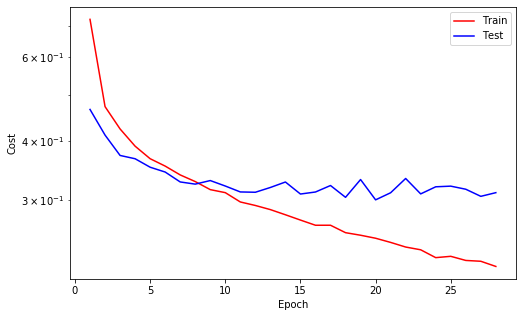

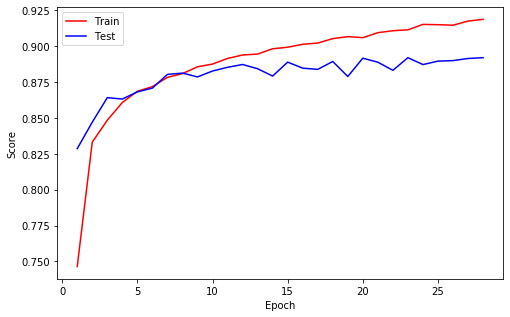

In [13]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    #Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break
    

## Load Best Model

In [14]:
# weights = torch.load("model/weights_best.pth", map_location="cpu")
# config = torch.load("model/configs.pth", map_location="cpu")

# model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
# model.load_state_dict(weights)
# model = model.to(device)

In [15]:
model

FashionClassifier(
  (fc): Sequential(
    (0): Flatten()
    (1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=10, bias=True)
      (1): LogSoftmax()
    )
  )
)

## Predict

In [16]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [17]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[train2cat[preds] for pred in preds]

tensor([1, 8, 1, 0, 3, 4, 0, 4, 0, 8, 2, 3, 9, 8, 8, 3, 2, 2, 5, 9, 0, 7, 3, 1,
        2, 1, 2, 0, 8, 8, 7, 8, 9, 9, 9, 5, 1, 0, 8, 6, 1, 9, 3, 6, 9, 6, 5, 7,
        7, 3, 4, 8, 3, 8, 1, 3, 3, 2, 9, 4, 8, 9, 7, 0, 7, 2, 9, 2, 3, 7, 9, 2,
        2, 8, 2, 7, 1, 9, 9, 5, 4, 2, 6, 7, 6, 9, 0, 7, 7, 5, 7, 8, 6, 1, 5, 0,
        2, 4, 4, 2, 2, 1, 5, 0, 0, 2, 1, 0, 4, 9, 4, 6, 9, 8, 3, 6, 4, 3, 1, 1,
        3, 7, 3, 8, 1, 4, 6, 1])

In [26]:
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

## Visualized

In [23]:
import matplotlib.pyplot as plt

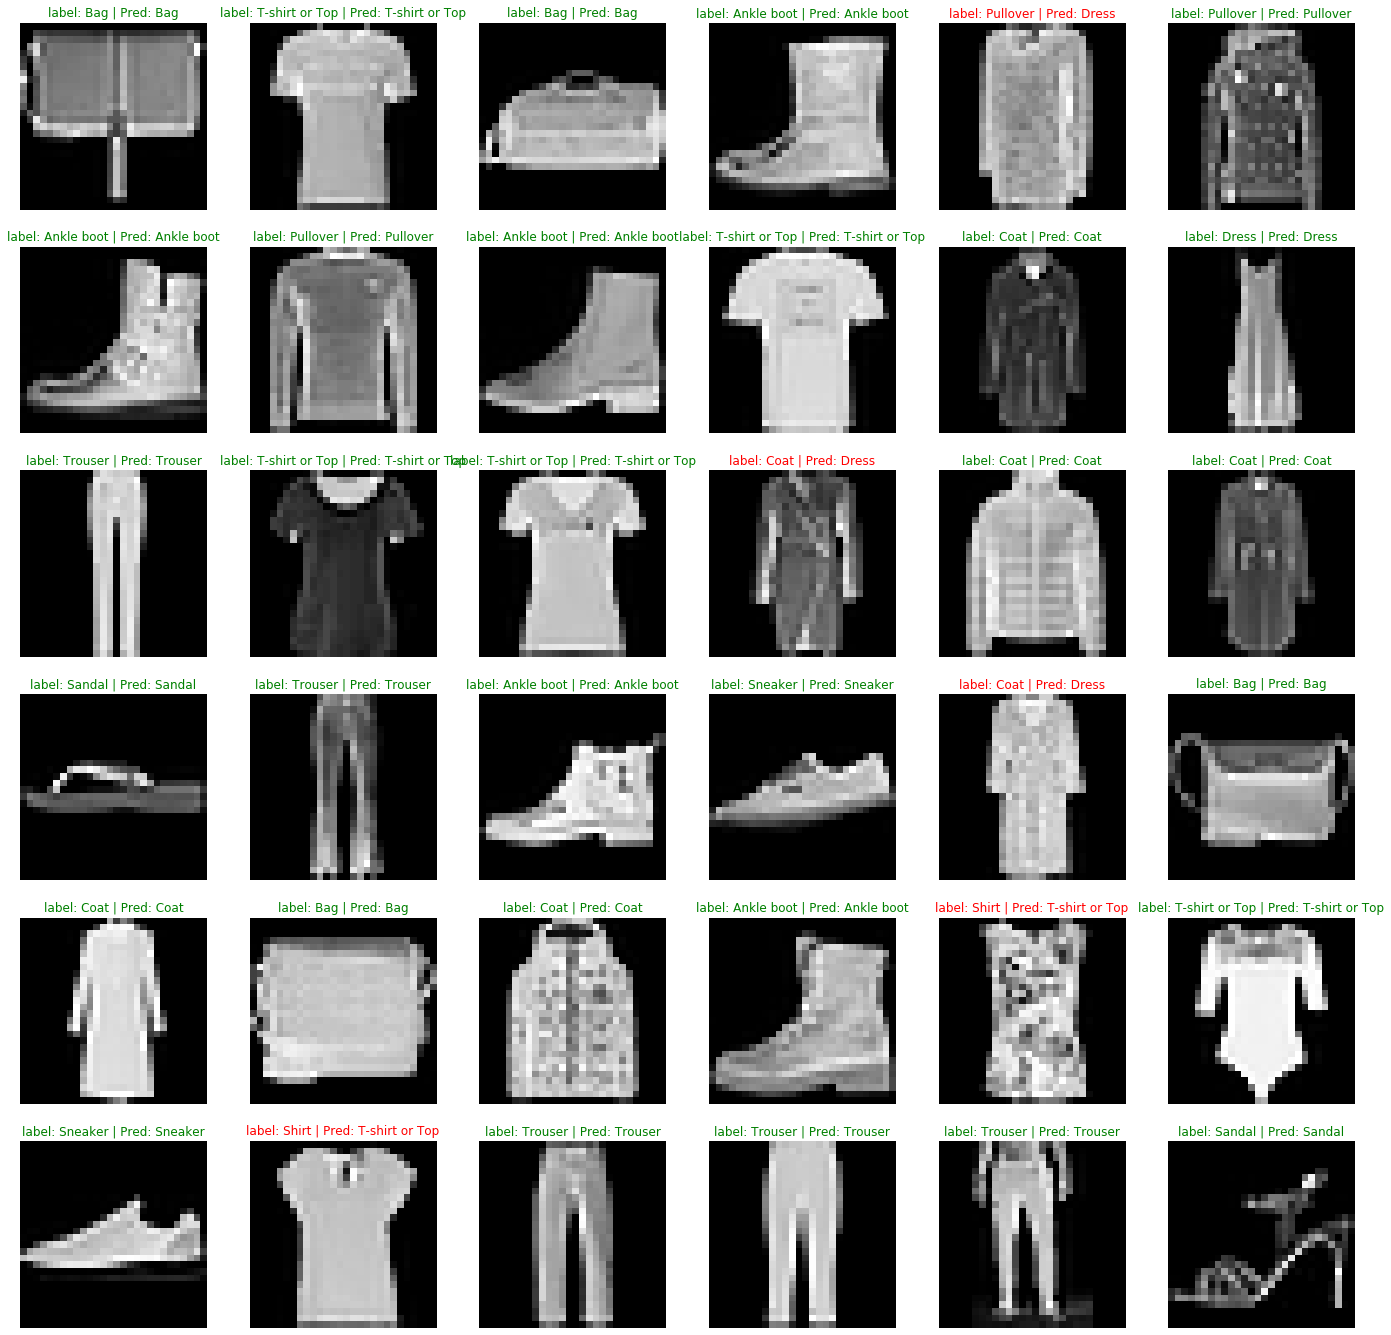

In [28]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap='gray')
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"label: {label} | Pred: {pred}", fontdict=font);
    ax.axis("off");